# Imports

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import sklearn
import json
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.compose import ColumnTransformer

plt.rcParams.update({'font.size':16})


Using TensorFlow backend.


In [2]:
# Import whole database
with open('../../data/feature_database.json') as json_database:
    database = json.load(json_database)

# Data Formatting

## Economy

In [3]:
# Concat data from sector economy
X_eco_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'economy':
        new_data = pd.read_json(database[i]['data'])
        if X_eco_raw is None:
            X_eco_raw = new_data
        else:
            X_eco_raw = pd.concat([X_eco_raw, new_data], axis=1, join="inner")

X_eco_raw.head()

,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy,FuelSale_rohbenzin_tons_insg,FuelSale_rohbenzin_tons_chemWeiterVera,FuelSale_rohbenzin_tons_sonstige
2005-01-01,85.3,5086847,4246.440011,5506.678548,83.5,87.7,79.3,77.7,104.5,1632220,1631127,1093
2005-02-01,85.6,5288245,4344.744019,5737.214453,85.0,83.9,80.5,80.4,99.8,1499439,1497408,2031
2005-03-01,86.0,5266085,4357.401460,5696.047894,98.1,98.3,90.5,89.4,112.1,1550679,1549418,1261
2005-04-01,85.8,5052429,4293.807617,5708.181431,96.3,97.8,99.4,99.0,116.0,1507829,1504132,3697
2005-05-01,85.9,4884238,4329.549139,5751.507302,94.6,94.3,112.7,111.5,122.9,1474656,1471632,3024


In [4]:
X_eco_raw['date'] = X_eco_raw.index
X_eco_raw.date = pd.to_datetime(X_eco_raw.date).dt.to_period('m')
X_eco_raw.index = X_eco_raw.date
X_eco_raw = X_eco_raw.drop('date', axis=1)
X_eco_raw.head()

,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy,FuelSale_rohbenzin_tons_insg,FuelSale_rohbenzin_tons_chemWeiterVera,FuelSale_rohbenzin_tons_sonstige
date,,,,,,,,,,,,
2005-01,85.3,5086847,4246.440011,5506.678548,83.5,87.7,79.3,77.7,104.5,1632220,1631127,1093
2005-02,85.6,5288245,4344.744019,5737.214453,85.0,83.9,80.5,80.4,99.8,1499439,1497408,2031
2005-03,86.0,5266085,4357.401460,5696.047894,98.1,98.3,90.5,89.4,112.1,1550679,1549418,1261
2005-04,85.8,5052429,4293.807617,5708.181431,96.3,97.8,99.4,99.0,116.0,1507829,1504132,3697
2005-05,85.9,4884238,4329.549139,5751.507302,94.6,94.3,112.7,111.5,122.9,1474656,1471632,3024


## Mobility

In [5]:
# Concat data from sector mobility
X_mob_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'mobility':
        new_data = pd.read_json(database[i]['data'])
        if X_mob_raw is None:
            X_mob_raw = new_data
        else:
            X_mob_raw = pd.concat([X_mob_raw, new_data], axis=1, join="inner")

X_mob_raw.head()

,M_KFZ,M_SV,M_LV,FuelSale_tons_ottokraftstoff_insg,FuelSale_tons_ottokraftstoff_militaer,FuelSale_tons_ottokraftstoff_sonstige,FuelSale_tons_dieselkraftstoff_insg,FuelSale_tons_dieselkraftstoff_schifffahrt,FuelSale_tons_dieselkraftstoff_militaer,FuelSale_tons_dieselkraftstoff_sonstige,FuelSale_tons_flugkraftstoff_schwer_insg,FuelSale_tons_flugkraftstoff_schwer_luftfahrt,FuelSale_tons_flugkraftstoff_schwer_militaer,FuelSale_tons_flugkraftstoff_schwer_sonstige,M_AviationTotalStartsAndLandings,M_InlandShippingTotalTransportPerformance,M_ShipsGermanFlag,M_ShipsForeignFlag,M_TotalRailFreights
2011-01-01,9.163182e+05,169467.115962,750949.929440,1519000,9157,1509843,2311195,11934,1254,2298007,629657,577369,8650,43638,157923.0,3189,2290912,21139202,8076598488
2011-02-01,9.228540e+05,180239.437819,749058.876655,1427494,8848,1418646,2443433,13238,1263,2428932,579036,522739,13632,42665,156000.0,4363,2029008,17342809,8921846067
2011-03-01,1.016968e+06,213801.934974,810814.414153,1625129,9612,1615517,2823922,16720,1523,2805679,671266,615881,13563,41822,181547.0,5462,2207955,19158437,10551559425
2011-04-01,9.952840e+05,191174.978164,807489.501513,1617986,9745,1608241,2651636,15382,1305,2634949,691378,631931,13229,46218,178565.0,4543,2198525,18988716,9301455105
2011-05-01,1.032499e+06,216044.506250,823418.977051,1789329,9870,1779459,2917399,17289,1080,2899030,738227,670475,15654,52098,198289.0,4326,2784340,20470142,10658822441


In [6]:
X_mob_raw['date'] = X_mob_raw.index
X_mob_raw.date = pd.to_datetime(X_mob_raw.date).dt.to_period('m')
X_mob_raw.index = X_mob_raw.date
X_mob_raw = X_mob_raw.drop('date', axis=1)
X_mob_raw.head()

,M_KFZ,M_SV,M_LV,FuelSale_tons_ottokraftstoff_insg,FuelSale_tons_ottokraftstoff_militaer,FuelSale_tons_ottokraftstoff_sonstige,FuelSale_tons_dieselkraftstoff_insg,FuelSale_tons_dieselkraftstoff_schifffahrt,FuelSale_tons_dieselkraftstoff_militaer,FuelSale_tons_dieselkraftstoff_sonstige,FuelSale_tons_flugkraftstoff_schwer_insg,FuelSale_tons_flugkraftstoff_schwer_luftfahrt,FuelSale_tons_flugkraftstoff_schwer_militaer,FuelSale_tons_flugkraftstoff_schwer_sonstige,M_AviationTotalStartsAndLandings,M_InlandShippingTotalTransportPerformance,M_ShipsGermanFlag,M_ShipsForeignFlag,M_TotalRailFreights
date,,,,,,,,,,,,,,,,,,,
2011-01,9.163182e+05,169467.115962,750949.929440,1519000,9157,1509843,2311195,11934,1254,2298007,629657,577369,8650,43638,157923.0,3189,2290912,21139202,8076598488
2011-02,9.228540e+05,180239.437819,749058.876655,1427494,8848,1418646,2443433,13238,1263,2428932,579036,522739,13632,42665,156000.0,4363,2029008,17342809,8921846067
2011-03,1.016968e+06,213801.934974,810814.414153,1625129,9612,1615517,2823922,16720,1523,2805679,671266,615881,13563,41822,181547.0,5462,2207955,19158437,10551559425
2011-04,9.952840e+05,191174.978164,807489.501513,1617986,9745,1608241,2651636,15382,1305,2634949,691378,631931,13229,46218,178565.0,4543,2198525,18988716,9301455105
2011-05,1.032499e+06,216044.506250,823418.977051,1789329,9870,1779459,2917399,17289,1080,2899030,738227,670475,15654,52098,198289.0,4326,2784340,20470142,10658822441


## Energy and households

In [7]:
# Concat data from sector engergy and households
X_eh_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'energy_households':
        new_data = pd.read_json(database[i]['data'])
        if X_eh_raw is None:
            X_eh_raw = new_data
        else:
            X_eh_raw = pd.concat([X_eh_raw, new_data], axis=1, join="inner")

X_eh_raw.head()

,CO2 of Coal-Energy in (Tonnen),CO2 of Gas in (Tonnen),CO2 of Biomass (Tonnen),CO2 of Hydropower (Tonnen),CO2 of Nuclear (Tonnen),heating_oil_price_in_usd,Deutschland,Deutschland,Deutschland
2007-03-01,20301552.62,2671491.27,355149.122723,49267.728,163265.172,66.790,6.18,63.3,159.6
2007-04-01,18090427.54,2235436.84,334754.479104,39440.736,141627.708,66.350,11.52,4.0,288.8
2007-05-01,17809621.82,2153908.19,356708.400428,47210.808,142169.232,66.615,14.16,131.1,221.6
2007-06-01,17625316.98,2120555.85,333615.733871,53689.536,133340.388,67.545,17.38,108.6,195.2
2007-07-01,18217962.96,1992911.34,368314.387891,55829.616,118069.584,67.335,17.24,121.3,192.3


In [8]:
X_eh_raw['date'] = X_eh_raw.index
X_eh_raw.date = pd.to_datetime(X_eh_raw.date).dt.to_period('m')
X_eh_raw.index = X_eh_raw.date
X_eh_raw = X_eh_raw.drop('date', axis=1)
X_eh_raw.head()

,CO2 of Coal-Energy in (Tonnen),CO2 of Gas in (Tonnen),CO2 of Biomass (Tonnen),CO2 of Hydropower (Tonnen),CO2 of Nuclear (Tonnen),heating_oil_price_in_usd,Deutschland,Deutschland,Deutschland
date,,,,,,,,,
2007-03,20301552.62,2671491.27,355149.122723,49267.728,163265.172,66.790,6.18,63.3,159.6
2007-04,18090427.54,2235436.84,334754.479104,39440.736,141627.708,66.350,11.52,4.0,288.8
2007-05,17809621.82,2153908.19,356708.400428,47210.808,142169.232,66.615,14.16,131.1,221.6
2007-06,17625316.98,2120555.85,333615.733871,53689.536,133340.388,67.545,17.38,108.6,195.2
2007-07,18217962.96,1992911.34,368314.387891,55829.616,118069.584,67.335,17.24,121.3,192.3


## Target Values

In [9]:
# Concat data from target values
Y_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'target_values':
        new_data = pd.read_json(database[i]['data'])
        if Y_raw is None:
            Y_raw = new_data
        else:
            Y_raw = pd.concat([Y_raw, new_data], axis=1, join="inner")

Y_raw.head()

,E_Mio.tonnes_CO2,M_Mio.tonnes_CO2,ECO_Mio.tonnes_CO2,Total_CO2_Emission
1990-01-01,59.831181,11.965386,32.015404,103.811971
1990-02-01,57.338215,12.509267,31.287781,101.135264
1990-03-01,52.352284,13.325089,30.560158,96.237531
1990-04-01,49.859318,14.004941,29.104913,92.969171
1990-05-01,44.873386,14.276881,27.649667,86.799934


In [10]:
Y_raw['date'] = Y_raw.index
Y_raw.date = pd.to_datetime(Y_raw.date).dt.to_period('m')
#Y_raw.to_timestamp('m')
Y_raw.index = Y_raw.date
Y_raw = Y_raw.drop('date', axis=1)
Y_raw.head()

,E_Mio.tonnes_CO2,M_Mio.tonnes_CO2,ECO_Mio.tonnes_CO2,Total_CO2_Emission
date,,,,
1990-01,59.831181,11.965386,32.015404,103.811971
1990-02,57.338215,12.509267,31.287781,101.135264
1990-03,52.352284,13.325089,30.560158,96.237531
1990-04,49.859318,14.004941,29.104913,92.969171
1990-05,44.873386,14.276881,27.649667,86.799934


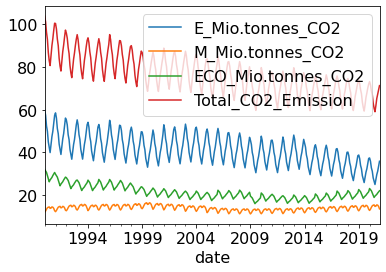

In [11]:
Y_raw.plot()

# Model Functions

## Model 1: Linear Regression

In [12]:
def my_LinearRegression(x,y,x_future,degree):
    print('################################################################################')
    print('Polynomial Fit/Linear Regression with degree: ', degree)
    print('################################################################################')
    poly = PolynomialFeatures(degree=1)
    X_train = poly.fit_transform(x)

    ### Scaling
    scaler = StandardScaler()
    #scaler = RobustScaler()
    #scaler = MinMaxScaler()

    # PCA
    pca = PCA()

    ### Validation
    cval = LeaveOneOut() 
    #cval = KFold(n_splits=2)

    ### Estimator
    estimator = LinearRegression()

    pipe = Pipeline(steps=[('scaler',scaler),('pca', pca), ('estimator', estimator)])
    param_grid = {'pca__n_components': range(1,X_train.shape[1]+1)}

    ### GridSearch
    search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(X_train, y)
    print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
    print(search.best_params_)

    plt.figure()
    plt.errorbar(range(1,X_train.shape[1]+1),-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'])
    #plt.plot(range(1,X_train.shape[1]+1),-search.cv_results_['mean_train_score'])
    plt.xticks(range(1,X_train.shape[1]+1))
    plt.xlabel("number of principle components")
    plt.ylabel("CV result score")
    plt.title("Grid search results for PCA components")
    plt.show()

    best_estimator = search.best_estimator_
    y_pred_train = best_estimator.predict(X_train)

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y,y_pred_train))
    #print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
    #print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

    # predicted/actual plot for test set
    ax = sns.jointplot(x=y_pred_train,y=y)
    ax.ax_joint.set_xlabel('Prediction')
    ax.ax_joint.set_ylabel('True')
    plt.show()

    y_pred_future = best_estimator.predict(poly.transform(x_future))
    return best_estimator, poly

## Model 2: Neuronal Network

In [13]:
def my_NeuronalNetwork(x,y,x_future):
    print('################################################################################')
    print('Neural Network Regression')
    print('################################################################################')
    scaler = MinMaxScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)

    X_train, X_val, Y_train, Y_val = train_test_split(x_scaled, y, test_size=.2)

    network = models.Sequential()
    network.add(layers.Dense(2, activation='relu', input_shape=(len(X_train[0]),)))
    #network.add(layers.Dense(2, activation='relu'))
    network.add(layers.Dense(1))
    network.summary()

    network.compile(optimizer=optimizers.RMSprop(lr=0.01),
              loss='mean_squared_error',
              metrics=['mse'])

    history = network.fit(X_train, Y_train, batch_size=5, epochs=200, validation_data=(X_val,Y_val), verbose=0)

    mse = history.history['mse'] #TO DO: take from the history dictionary of the model the training accuracy
    val_mse =  history.history['val_mse'] #TO DO: take from the history dictionary of the model the validation accuracy
    loss =  history.history['loss'] #TO DO: take from the history dictionary of the model the training loss
    val_loss =  history.history['val_loss'] #TO DO: take from the history dictionary of the model the validation loss 

    epochs = range(1, len(mse) + 1)

    # Plot the Loss
    plt.plot(loss)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'b', label='Training loss') 
    # b is for "solid blue line"
    plt.plot(epochs,  val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    y_pred_train = network.predict(x_scaled)
    ax = sns.jointplot(x=y_pred_train,y=y)
    ax.ax_joint.set_xlabel('Prediction')
    ax.ax_joint.set_ylabel('True')
    plt.show()

    x_future_scaled = scaler.transform(x_future)
    y_pred_future = network.predict(x_future_scaled)

    return network, scaler

## Model 3: PLSR

In [14]:
def my_PLSR(x,y,x_future):
    print('################################################################################')
    print('PLSR Regression')
    print('################################################################################')
          
    scaler = StandardScaler()
    cval = KFold(n_splits=10)
    plsr = PLSRegression()
    ct = ColumnTransformer([('scaler', scaler, np.arange(0,8))],remainder='passthrough')

    pipe = Pipeline(steps=[('scaler',ct), ('plsr', plsr)])
    param_grid = {'plsr__n_components': range(1,x.shape[1]+1)}

    search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(x, y)
    print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
    print(search.best_params_)

    plt.figure()
    plt.errorbar(range(1,x.shape[1]+1),-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
    plt.errorbar(range(1,x.shape[1]+1),-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
    plt.legend()
    plt.xticks(range(1,x.shape[1]+1))
    plt.xlabel("number of principle components")
    plt.title("Grid search results for PCA components")
    plt.show()

    best_estimator = search.best_estimator_
    y_pred_train = best_estimator.predict(x)

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

    ax = sns.jointplot(x=y_pred_train,y=y)
    ax.ax_joint.set_xlabel('Prediction')
    ax.ax_joint.set_ylabel('True')
    plt.show()

    y_pred_future = best_estimator.predict(x_future)
    return best_estimator

## Model 4: LASSO

In [15]:
def my_LASSO(x,y,x_future,alphas):
    print('################################################################################')
    print('LASSO Regression')
    print('################################################################################')
    
    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)

    cval = KFold(n_splits=10)
    lsso = Lasso()

    tuned_parameters = [{'alpha': alphas}]

    search = GridSearchCV(lsso, tuned_parameters, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(x_scaled, y)
    print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
    print(search.best_params_)

    plt.figure()
    plt.errorbar(alphas,-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
    plt.errorbar(alphas,-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
    plt.legend()
    plt.xticks(alphas)
    plt.xlabel("alpha")
    plt.ylabel("CV result score")
    plt.title("Grid search results for alpha")
    plt.show()

    best_estimator = search.best_estimator_
    y_pred_train = best_estimator.predict(x_scaled)


    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

    ax = sns.jointplot(x=y_pred_train.reshape(-1,1),y=y)
    ax.ax_joint.set_xlabel('Prediction')
    ax.ax_joint.set_ylabel('True')
    plt.show()

    x_future_scaled = scaler.transform(x_future)
    y_pred_future = best_estimator.predict(x_future_scaled).reshape(-1,1)
    return best_estimator, scaler

## Model 5: Ridge

In [16]:
def my_Ridge(x,y,x_future,alphas):
    print('################################################################################')
    print('Ridge Regression')
    print('################################################################################')
    
    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)

    cval = KFold(n_splits=10)
    rdge = Ridge()


    tuned_parameters = [{'alpha': alphas}]

    search = GridSearchCV(rdge, tuned_parameters, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
    search.fit(x_scaled, y)
    print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
    print(search.best_params_)

    plt.figure()
    plt.errorbar(alphas,-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'],label='Test')
    plt.errorbar(alphas,-search.cv_results_['mean_train_score'],yerr=search.cv_results_['std_train_score'],label='Train')
    plt.legend()
    plt.xticks(alphas)
    plt.xlabel("alpha")
    plt.ylabel("CV result score")
    plt.title("Grid search results for alpha")
    plt.show()

    best_estimator = search.best_estimator_
    y_pred_train = best_estimator.predict(x_scaled)

    print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(y,y_pred_train)))
    print("R2 training fit: %.03f " %r2_score(y,y_pred_train))

    ax = sns.jointplot(x=y_pred_train.reshape(-1,1),y=y)
    ax.ax_joint.set_xlabel('Prediction')
    ax.ax_joint.set_ylabel('True')
    plt.show()

    x_future_scaled = scaler.transform(x_future)
    y_pred_future = best_estimator.predict(x_future_scaled).reshape(-1,1)
    return best_estimator, scaler

## Function to run models

In [17]:
def RunModels(X, y):

    #prepare features and ground truth
    X_train = X[(X.index.year <= 2019)]
    
    X_test = X[(X.index.year > 2017)]
    X_test = X_test[(X_test.index.year <= 2020)]

    y_train = y[(y.index.year <= 2019)]
    y_train = y_train[(y_train.index >= X.index.min())]

    y_test = y[(y.index.year > 2017)]
    y_test = y_test[(y_test.index <= X_test.index.max())]
    
    #dataframe for numeric results
    arr_zeros = np.zeros((5,))
    df_result = pd.DataFrame({'r2_train':arr_zeros, 'rmse_train':arr_zeros}, index=['LR', 'NN', 'PLSR', 'LASSO', 'Ridge'])
    
    arr_zeros = np.zeros((y_test.shape[0],))
    df_result_arr = pd.DataFrame({'LR':arr_zeros, 'NN':arr_zeros, 'PLSR':arr_zeros, 'LASSO':arr_zeros, 'Ridge':arr_zeros, 'OekoInstitue': np.array(y_test.values).flatten()}, index=y_test.index)

    arr_zeros = np.zeros((y_train.shape[0],))
    df_result_arr_train = pd.DataFrame({'LR':arr_zeros, 'NN':arr_zeros, 'PLSR':arr_zeros, 'LASSO':arr_zeros, 'Ridge':arr_zeros, 'OekoInstitue': np.array(y_train.values).flatten()}, index=y_train.index)

    
#Models
    #Linear/Non-Linear Regression 
    LR, LR_POLY = my_LinearRegression(X_train,y_train,X_test,2)
    y_pred_train_LR = LR.predict(LR_POLY.transform(X_train))
    y_pred_test_LR = LR.predict(LR_POLY.transform(X_test))

    df_result['r2_train']['LR'] = r2_score(y_train,y_pred_train_LR)
    df_result['rmse_train']['LR'] = np.sqrt(mean_squared_error(y_train,y_pred_train_LR))
    
    df_result_arr['LR'] = y_pred_test_LR
    df_result_arr_train['LR'] = y_pred_train_LR
    
    #NN
    NN, NN_SCALER = my_NeuronalNetwork(X_train,y_train,X_test)

    X_train_scaled = NN_SCALER.transform(X_train)
    X_test_scaled = NN_SCALER.transform(X_test)

    y_pred_train_NN = NN.predict(X_train_scaled)
    y_pred_test_NN = NN.predict(X_test_scaled)

    df_result['r2_train']['NN'] = r2_score(y_train,y_pred_train_NN)
    df_result['rmse_train']['NN'] = np.sqrt(mean_squared_error(y_train,y_pred_train_NN))
    
    df_result_arr['NN'] = y_pred_test_NN
    df_result_arr_train['NN'] = y_pred_train_NN
    
    #PLSR
    PLSR = my_PLSR(X_train,y_train,X_test)
    y_pred_train_PLSR = PLSR.predict(X_train)
    y_pred_test_PLSR = PLSR.predict(X_test)

    df_result['r2_train']['PLSR'] = r2_score(y_train,y_pred_train_PLSR)
    df_result['rmse_train']['PLSR'] = np.sqrt(mean_squared_error(y_train,y_pred_train_PLSR))
    
    df_result_arr['PLSR'] = y_pred_test_PLSR
    df_result_arr_train['PLSR'] = y_pred_train_PLSR
    
    #LASSO
    alphas = np.linspace(0,0.2,50)

    LASSO, LASSO_SCALER = my_LASSO(X_train,y_train,X_test,alphas)
    X_train_scaled = LASSO_SCALER.transform(X_train)
    X_test_scaled = LASSO_SCALER.transform(X_test)

    y_pred_train_LASSO = LASSO.predict(X_train_scaled)
    y_pred_test_LASSO = LASSO.predict(X_test_scaled)

    df_result['r2_train']['LASSO'] = r2_score(y_train,y_pred_train_LASSO)
    df_result['rmse_train']['LASSO'] = np.sqrt(mean_squared_error(y_train,y_pred_train_LASSO))

    df_result_arr['LASSO'] = y_pred_test_LASSO
    df_result_arr_train['LASSO'] = y_pred_train_LASSO
    
    #Ridge
    alphas = np.linspace(5,8,50)

    RIDGE, Ridge_SCALER = my_Ridge(X_train,y_train,X_test,alphas)

    X_train_scaled = Ridge_SCALER.transform(X_train)
    X_test_scaled = Ridge_SCALER.transform(X_test)

    y_pred_train_Ridge = RIDGE.predict(X_train_scaled)
    y_pred_test_Ridge = RIDGE.predict(X_test_scaled)

    df_result['r2_train']['Ridge'] = r2_score(y_train,y_pred_train_Ridge)
    df_result['rmse_train']['Ridge'] = np.sqrt(mean_squared_error(y_train,y_pred_train_Ridge))

    df_result_arr['Ridge'] = y_pred_test_Ridge
    df_result_arr_train['Ridge'] = y_pred_train_Ridge

    return df_result, df_result_arr, df_result_arr_train

# Mapping

## Economy

################################################################################
Polynomial Fit/Linear Regression with degree:  2
################################################################################
Best parameter RMSE=0.895):
{'pca__n_components': 11}


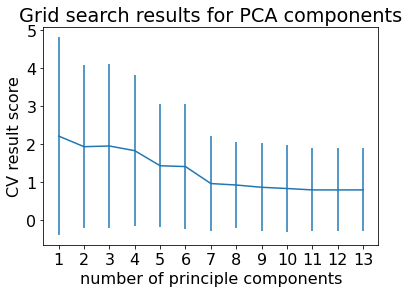

RMSE training fit: 0.837
R2 training fit: 0.677 


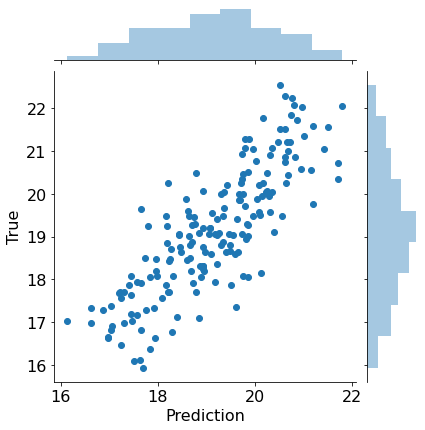

################################################################################
Neural Network Regression
################################################################################
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2)                 26        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


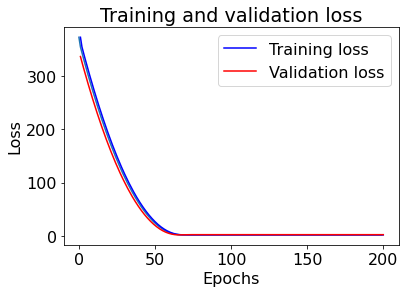

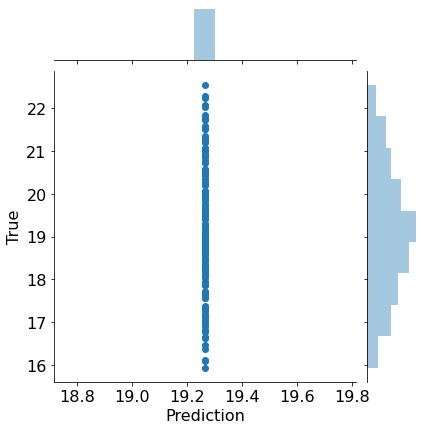

################################################################################
PLSR Regression
################################################################################
Best parameter RMSE=1.121):
{'plsr__n_components': 7}


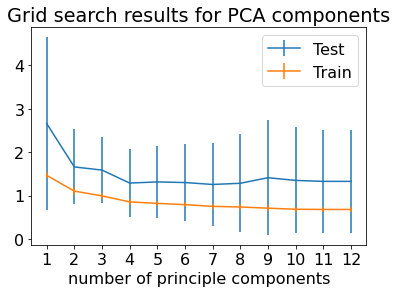

RMSE training fit: 0.885
R2 training fit: 0.639 


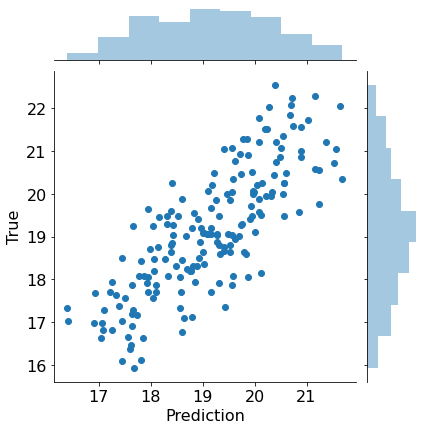

################################################################################
LASSO Regression
################################################################################
Best parameter RMSE=1.100):
{'alpha': 0.0163265306122449}


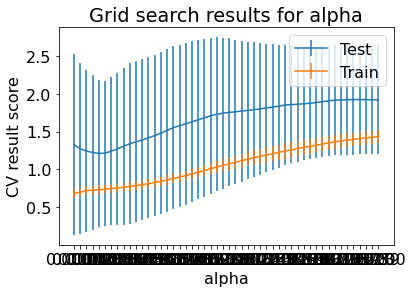

RMSE training fit: 0.864
R2 training fit: 0.656 


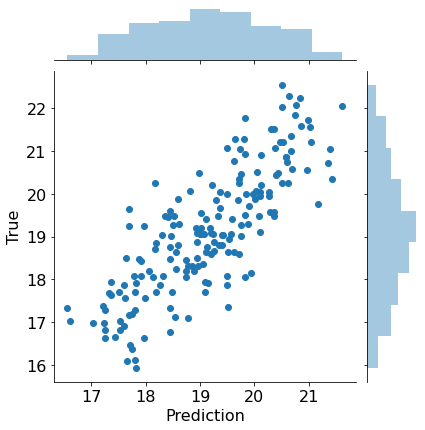

################################################################################
Ridge Regression
################################################################################
Best parameter RMSE=1.121):
{'alpha': 5.0}


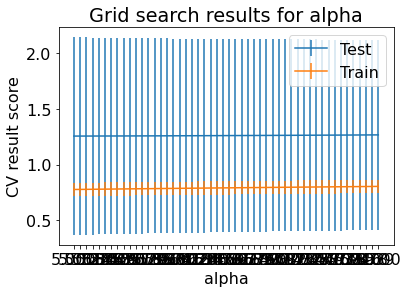

RMSE training fit: 0.887
R2 training fit: 0.637 


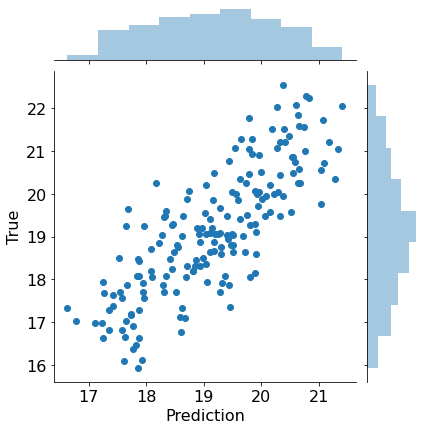

In [18]:
X = X_eco_raw
y = Y_raw[['ECO_Mio.tonnes_CO2']]

df_result_ECO, df_result_arr_ECO, df_result_arr_train_ECO = RunModels(X, y)

Text(0.5, 1.0, 'Sector: Economy')

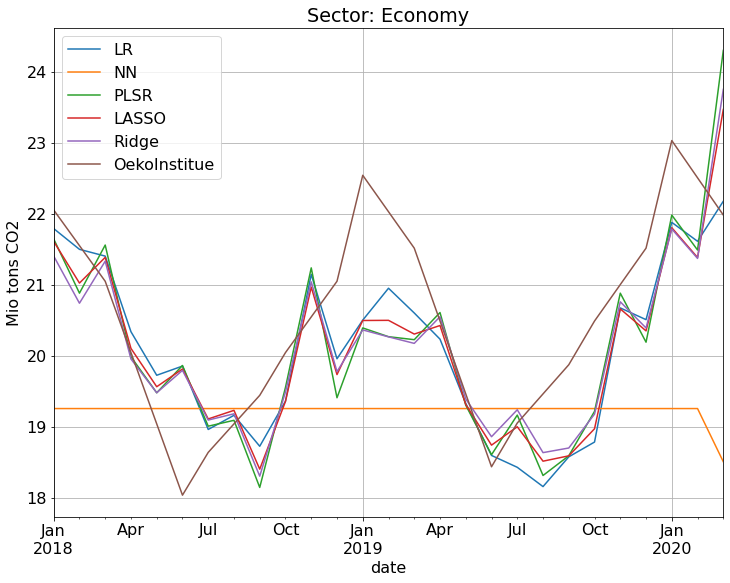

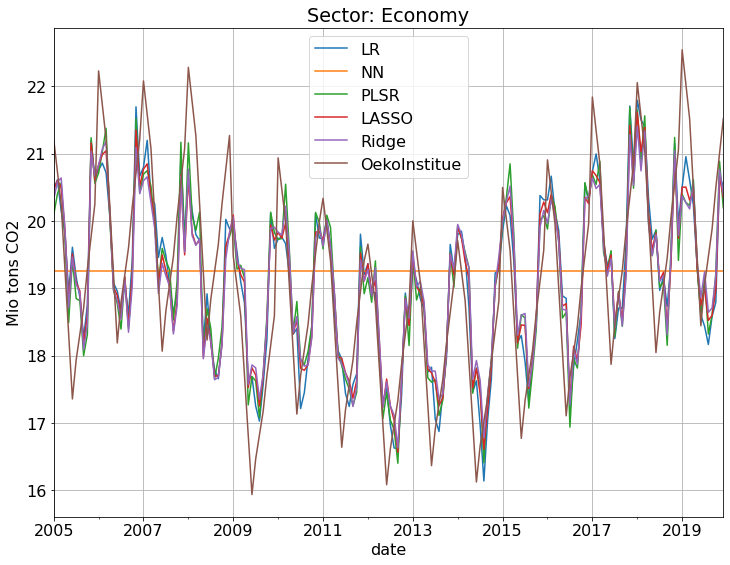

In [19]:
df_result_ECO
df_result_arr_ECO.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Economy')

df_result_arr_train_ECO.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Economy')


## Mobility

################################################################################
Polynomial Fit/Linear Regression with degree:  2
################################################################################
Best parameter RMSE=0.426):
{'pca__n_components': 14}


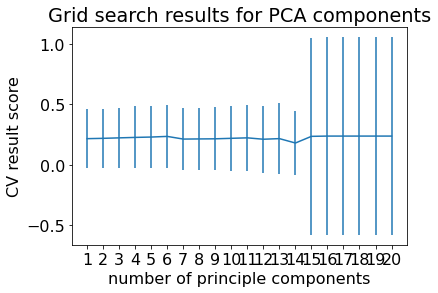

RMSE training fit: 0.365
R2 training fit: 0.845 


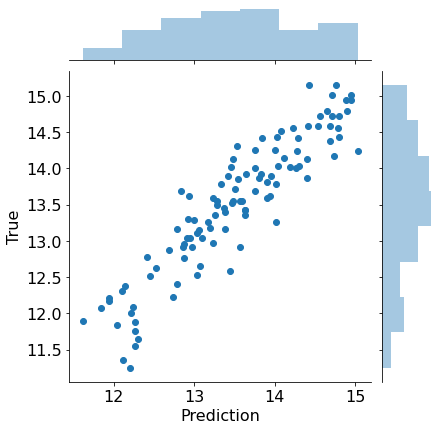

################################################################################
Neural Network Regression
################################################################################
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 2)                 40        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 43
Trainable params: 43
Non-trainable params: 0
_________________________________________________________________


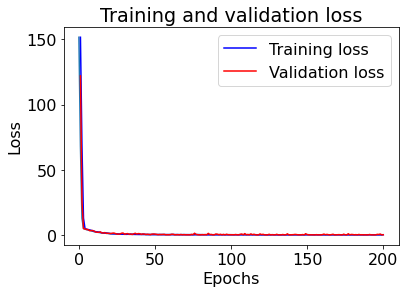

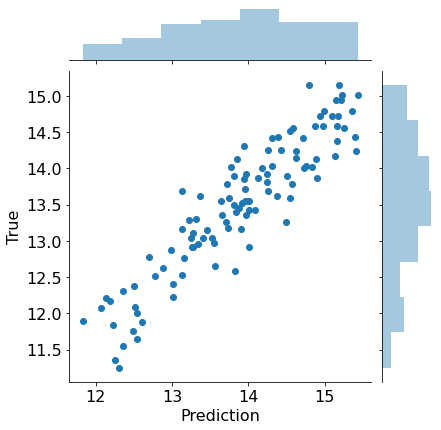

################################################################################
PLSR Regression
################################################################################
Best parameter RMSE=0.453):
{'plsr__n_components': 7}


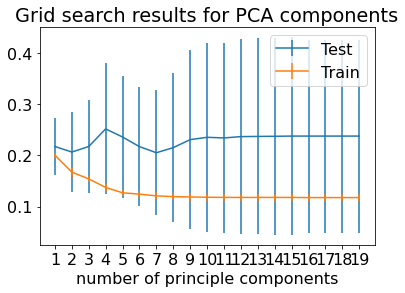

RMSE training fit: 0.352
R2 training fit: 0.856 


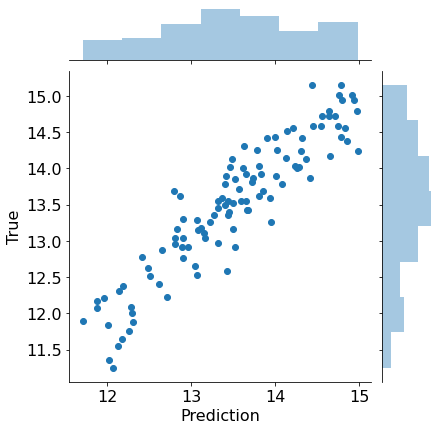

################################################################################
LASSO Regression
################################################################################
Best parameter RMSE=0.444):
{'alpha': 0.02448979591836735}


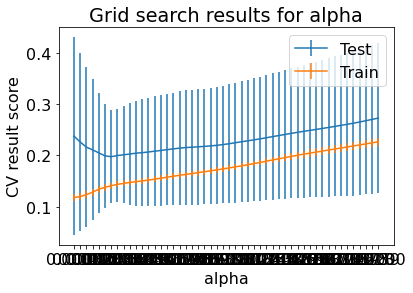

RMSE training fit: 0.378
R2 training fit: 0.833 


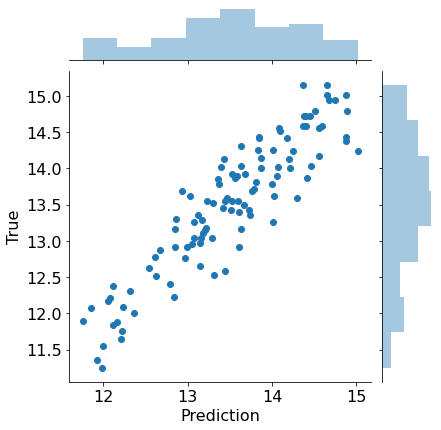

################################################################################
Ridge Regression
################################################################################
Best parameter RMSE=0.439):
{'alpha': 8.0}


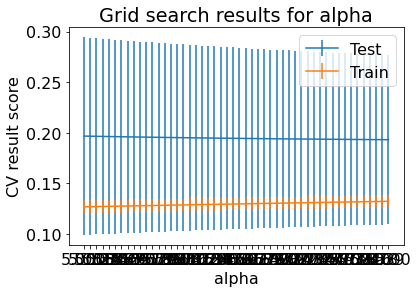

RMSE training fit: 0.365
R2 training fit: 0.844 


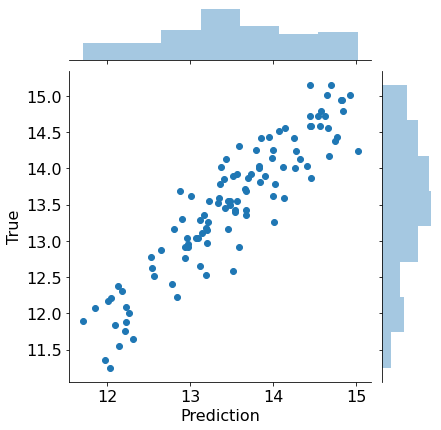

In [20]:
X = X_mob_raw
y = Y_raw[['M_Mio.tonnes_CO2']]

df_result_M,df_result_arr_M,df_result_arr_train_M = RunModels(X, y)


Text(0.5, 1.0, 'Sector: Mobility')

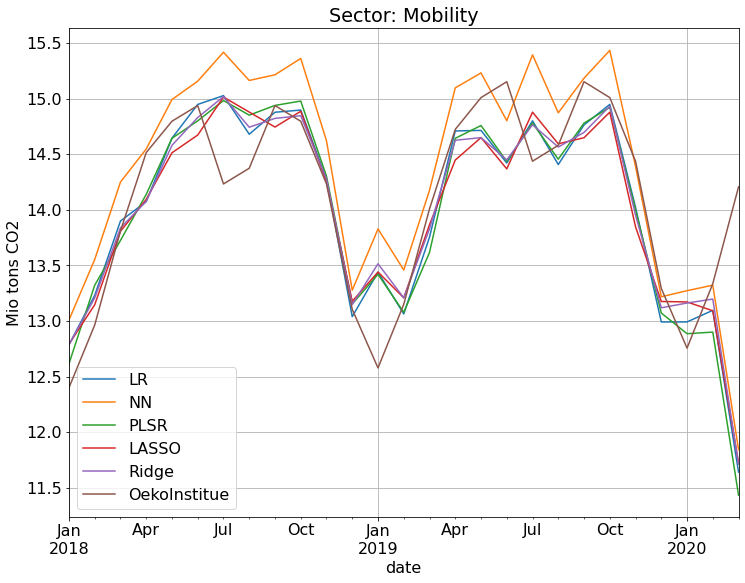

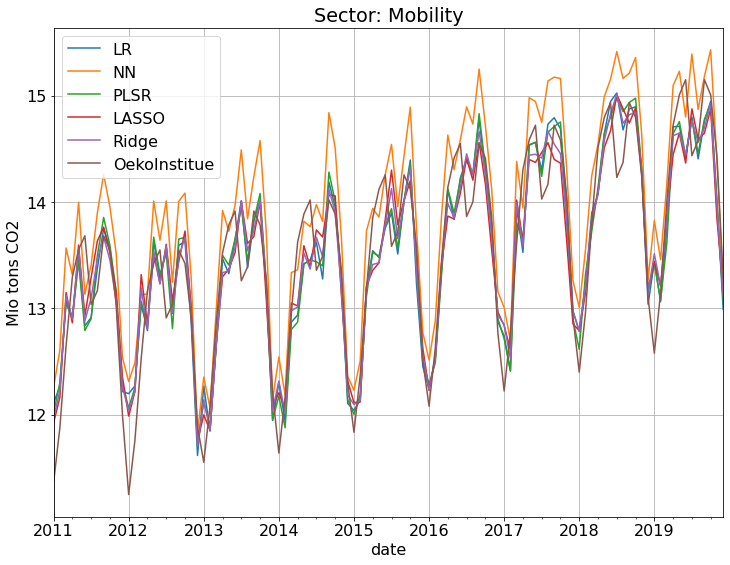

In [21]:
df_result_M
df_result_arr_M.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Mobility')

df_result_arr_train_M.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Mobility')


## Energy and Household

################################################################################
Polynomial Fit/Linear Regression with degree:  2
################################################################################
Best parameter RMSE=1.707):
{'pca__n_components': 9}


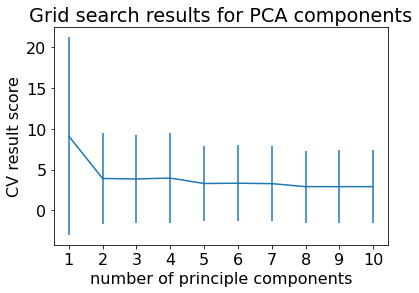

RMSE training fit: 1.595
R2 training fit: 0.908 


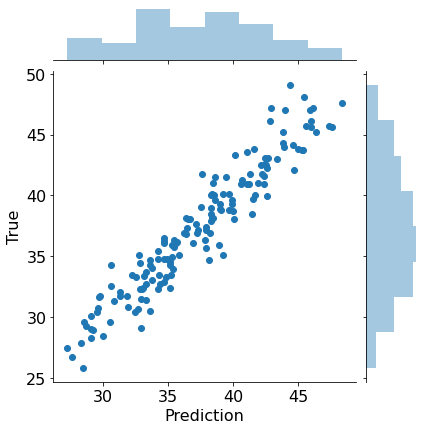

################################################################################
Neural Network Regression
################################################################################
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 3         
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


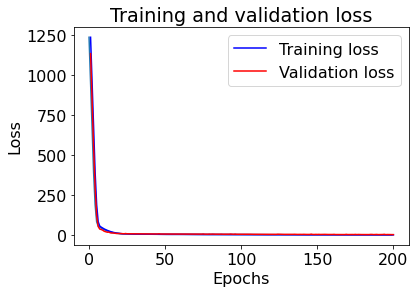

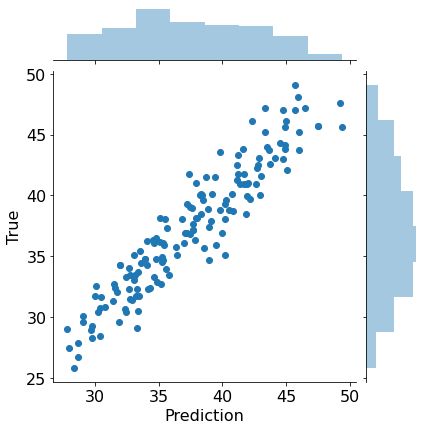

################################################################################
PLSR Regression
################################################################################
Best parameter RMSE=1.952):
{'plsr__n_components': 7}


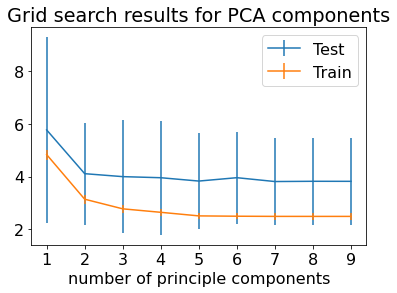

RMSE training fit: 1.595
R2 training fit: 0.908 


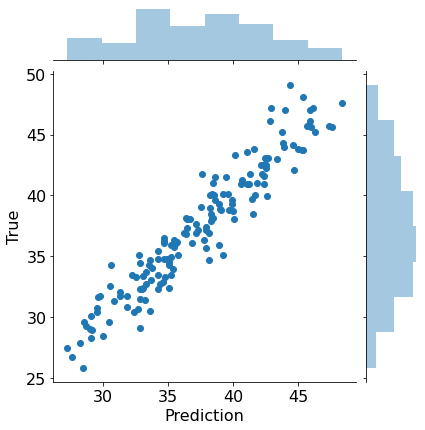

################################################################################
LASSO Regression
################################################################################
Best parameter RMSE=1.879):
{'alpha': 0.05714285714285715}


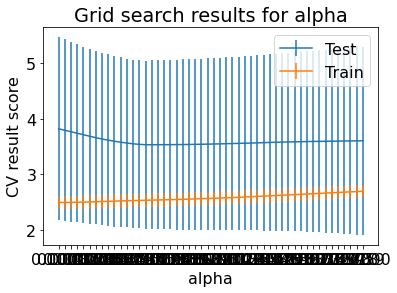

RMSE training fit: 1.605
R2 training fit: 0.907 


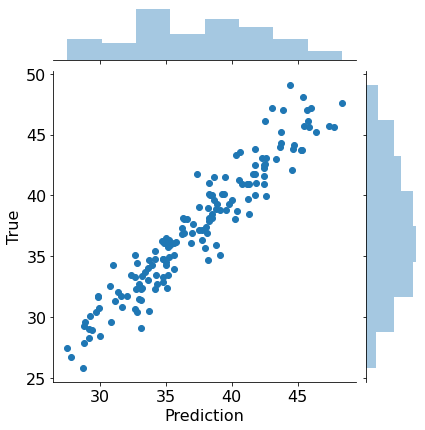

################################################################################
Ridge Regression
################################################################################
Best parameter RMSE=1.941):
{'alpha': 6.224489795918368}


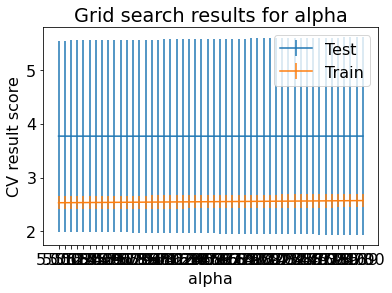

RMSE training fit: 1.610
R2 training fit: 0.906 


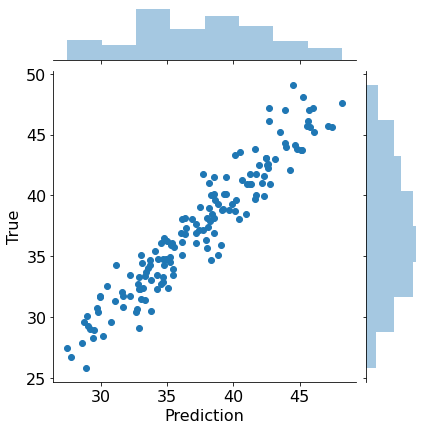

In [22]:
X = X_eh_raw
y = Y_raw[['E_Mio.tonnes_CO2']]

df_result_EH,df_result_arr_EH,df_result_arr_train_EH = RunModels(X, y)

Text(0.5, 1.0, 'Sector: Energy and Household')

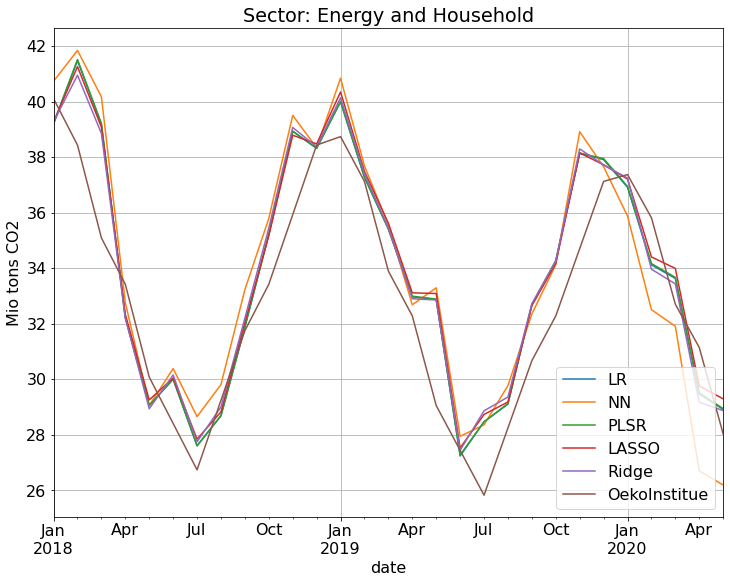

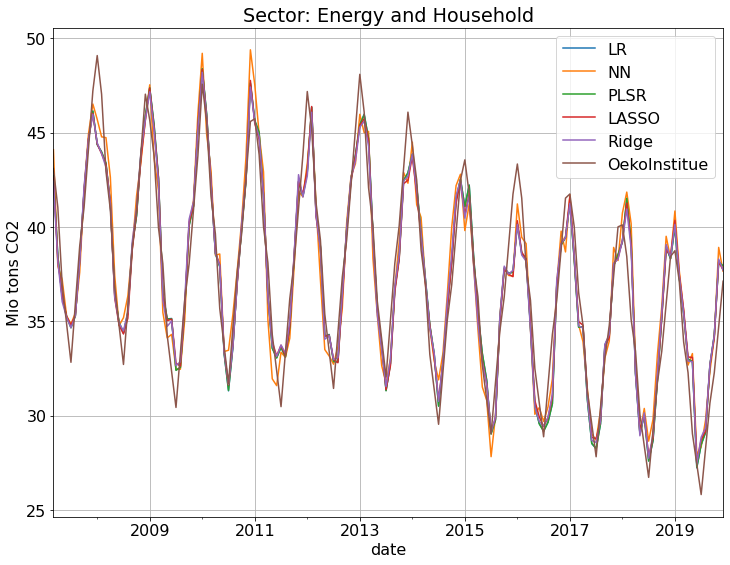

In [23]:
df_result_EH
df_result_arr_EH.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Energy and Household')

df_result_arr_train_EH.plot(figsize=(12,9))
plt.grid()
plt.ylabel('Mio tons CO2')
plt.title('Sector: Energy and Household')
